# Import all necessary modules. 
- Matplot lib was used for plotting, along with the 3D toolkits.
- NumPy used for data arrays.
- SciPy used for least-squares plane fitting.

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from aeropy.xfoil_module import *
import scipy.linalg

Define the enviromental constants, Fluid density $\rho$ and graviational acceleration $g$. Also definie the input parameters, given in the Tables within the report.

In [14]:
RHO = 997
G = 9.81

In [15]:
HYDROFOIL = 'naca0015' # 2D hydrofoil section, either NACA or can parse text file name.
SYMETRICAL = True # boolean to determine if the hydrofoil section is symetrical, used for error mitigation in plane fitting.

TAKEOFF_LIFT = 850  # Use this variable to specify the required take-off lift.

SPAN = 0.988 # The 3D finite wing span of the hydrofoil
CHORD = 0.095 # Total chord, c
FLAP_POSITION = 0.65 
FLAP_DENSITY = 1800
THICKNESS_AT_FLAP = 0.00741 # used for flap volume calculation


Calculate some initial calculated parameters:

In [16]:
FLAP_CHORD = (1 - FLAP_POSITION) * CHORD # chord of the control flap, l
FLAP_VOLUME_PER_SPAN = 0.5 * FLAP_CHORD * THICKNESS_AT_FLAP # volume per span of the control flap, nabla
FLAP_COM = 1/3 * FLAP_CHORD # Centre Of Mass COM of the flap, 1/3 of the way along since triangular


Next, variables that define the XFOIL data collection are defined.

In [17]:
RESOLUTION = 10 # Resolution x Resolution grid of data points
MIN_ALFA, MAX_ALFA = 0, 5 # min and max alfa to be collected
MIN_PHI, MAX_PHI = 0.001, 15 # min and max phi to be calculated
MIN_VELOCITY, MAX_VELOCITY = 0, 15 # the velocity range to be analysed.

Finally, the data can be collected from XFOIL using AeroPy. The data can be split from the polar output by using string slicing. 

In [18]:
alfas = np.linspace(MIN_ALFA, MAX_ALFA, RESOLUTION)  # define x-axis linear array 
phis = np.linspace(MIN_PHI, MAX_PHI, RESOLUTION)  # define y-axis linear array

#phis = abs(np.flip(phis) - 20)

#print(phis)
alfas, phis = np.meshgrid(alfas,phis)  # create a meshgrid of the anaysis array
    
alfasFlatten = alfas.flatten() # flatten both alfas and phis to loop through
phisFlatten = phis.flatten()

xfoilHM = np.zeros(len(alfasFlatten))  # 2d zeros for hinge moments
xfoilCL = np.zeros(len(alfasFlatten))  # 2d zeros for lift coefficients



for i in range(0,RESOLUTION):
    call(HYDROFOIL, alfas=alfas[0], output='Polar', Reynolds=0, Mach=0,
        plots=False, NACA=True, GDES=True, iteration=10, flap=[FLAP_POSITION,0.0,phis[:,0][i]],
        PANE=False, NORM=True) # call aeropy Xfoil
    
    file = open('polar','r')  # open the polar file created by Xfoil
    lines = file.readlines()  # read all lines from the file
    file.close  # close the file

   
for j in range(0,RESOLUTION**2):  # one iteration of the loop for each element of the analysis grid
    #print('AOA: {0}  Flap angle:  {1}    cl: {2}    hm: {3}'.format(alfasFlatten[j],phis[0][i],lines[12+j][11:17],lines[12+j][48:55]))
    xfoilHM[j] = round(float(lines[12+j][48:55]),5) # hinge moment
    xfoilCL[j] = round(float(lines[12+j][11:17]),5) # lift coefficient

Once both the hinge moment and lift coefficient data has been collected, SciPy and Matplotlib can be used to calculate the plane of best fit, and to plot the 3D plots for visualisation.

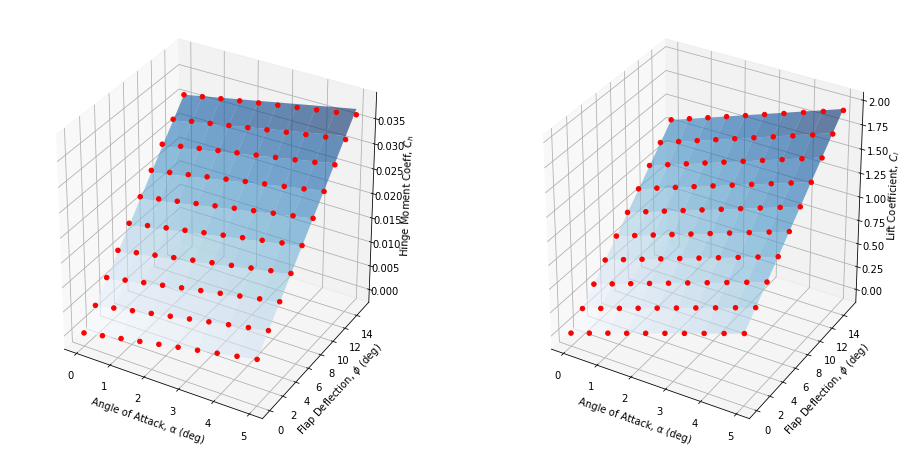

Xfoil Hinge Moment Plane:     0.001345X + 0.002048Y + 0.000000        r-squared 1.000
Xfoil Lift Coefficient Plane: 0.123353X + 0.088150Y + 0.000000        r-squared 0.999


In [19]:
xfoilHM = np.c_[alfasFlatten, phisFlatten, xfoilHM]  # reconstruct data into x,y,z coords array
xfoilCL = np.c_[alfasFlatten, phisFlatten, xfoilCL]  # reconstruct data into x,y,z coords array

if SYMETRICAL == True:
    lhsMatrixHM = np.c_[xfoilHM[:,0], xfoilHM[:,1], np.zeros(xfoilHM.shape[0])]  # construct matrix of x,y,0 * n
    lhsMatrixCL = np.c_[xfoilCL[:,0], xfoilCL[:,1], np.zeros(xfoilCL.shape[0])]  # construct matrix of x,y,0 * n

else:
    lhsMatrixHM = np.c_[xfoilHM[:,0], xfoilHM[:,1], np.ones(xfoilHM.shape[0])]  # construct matrix of x,y,1 * n
    lhsMatrixCL = np.c_[xfoilCL[:,0], xfoilCL[:,1], np.ones(xfoilCL.shape[0])]  # construct matrix of x,y,1 * n
    
rhsMatrixHM,_,_,_ = scipy.linalg.lstsq(lhsMatrixHM, xfoilHM[:,2])  # calculate coefficients of the HM plane
rhsMatrixCL,_,_,_ = scipy.linalg.lstsq(lhsMatrixCL, xfoilCL[:,2])  # calculate coefficients of the CL plane

momentPlane = rhsMatrixHM.copy() # apply variable change from phi to phi'
momentPlane[1] = -momentPlane[1]
momentPlane[2] = momentPlane[2] - momentPlane[1]*MAX_PHI

liftCoeffPlane = rhsMatrixCL.copy()  # apply variable change from phi to phi'
liftCoeffPlane[1] = -liftCoeffPlane[1]
liftCoeffPlane[2] = liftCoeffPlane[2] - liftCoeffPlane[1]*MAX_PHI
      
X,Y = alfas, phis  # define axis for plotting

ZHM = rhsMatrixHM[0]*X + rhsMatrixHM[1]*Y + rhsMatrixHM[2]   # calculate the plane for display
ZHMperp = momentPlane[0]*X + momentPlane[1]*Y + momentPlane[2]

ZCL = rhsMatrixCL[0]*X + rhsMatrixCL[1]*Y + rhsMatrixCL[2]   # calculate the plane for display
ZCLperp = liftCoeffPlane[0]*X + liftCoeffPlane[1]*Y + liftCoeffPlane[2]

temp1 = xfoilHM[:,2] # Calculate R^2 value for the hinge moment
SStot1 = ((temp1 - temp1.mean())**2).sum()
SSres1 = ((temp1 - np.dot(lhsMatrixHM,rhsMatrixHM))**2).sum()
rSquared1 = 1 - SSres1 / SStot1

temp2 = xfoilCL[:,2] # Calculate R^2 value for the lift coefficient
SStot2 = ((temp2 - temp2.mean())**2).sum()
SSres2 = ((temp2 - np.dot(lhsMatrixCL,rhsMatrixCL))**2).sum()
rSquared2 = 1 - SSres2 / SStot2


#Plotting the 3D Figures using Matplot lib
fig = plt.figure(figsize = (16, 8))

ax = fig.add_subplot(1,2,1, projection = '3d', zlabel='Hinge Moment Coeff, $C_h$')
ax.scatter(xfoilHM[:,0], xfoilHM[:,1], xfoilHM[:,2], c='red', alpha = 1)
ax.plot_surface(X, Y, ZHM, rstride=1, cstride=1,
                cmap='Blues', alpha = 0.6, edgecolor='none')

ax.set(xlabel='Angle of Attack, α (deg)', ylabel='Flap Deflection, $\phi$ (deg)')

ax = fig.add_subplot(1,2,2, projection = '3d', zlabel='Lift Coefficient, $C_l$')
ax.scatter(xfoilCL[:,0], xfoilCL[:,1], xfoilCL[:,2], c='red', alpha = 1)

ax.plot_surface(X, Y, ZCL, rstride=1, cstride=1,
                cmap='Blues', alpha = 0.6, edgecolor='none')

ax.set(xlabel='Angle of Attack, α (deg)', ylabel='Flap Deflection, $\phi$ (deg)')

plt.show()

print("Xfoil Hinge Moment Plane:     {0:.6f}X + {1:.6f}Y + {2:.6f}        r-squared {3:.3f}".format(rhsMatrixHM[0],rhsMatrixHM[1],rhsMatrixHM[2],rSquared2))
print("Xfoil Lift Coefficient Plane: {0:.6f}X + {1:.6f}Y + {2:.6f}        r-squared {3:.3f}".format(rhsMatrixCL[0],rhsMatrixCL[1],rhsMatrixCL[2],rSquared1))

In [20]:
a = momentPlane[0]
b = momentPlane[1]
c = momentPlane[2]

d = liftCoeffPlane[0]
e = liftCoeffPlane[1]
f = liftCoeffPlane[2]


AOA = ((e*c) - (f*b)) / ((d*b) - (e*a)) # Calculate the angle of attack necessary for constant lfit


aspectRatio = SPAN/CHORD  # aspect ratio calculation

MAX_CL = (liftCoeffPlane[0] * AOA + liftCoeffPlane[2]) / (1 + (2/aspectRatio)) # Calculate maximum 3D lift coefficient

takeoffVelocity = np.sqrt((2*TAKEOFF_LIFT)/(MAX_CL * RHO * CHORD * SPAN)) # Calculate the required take off velocity

massPerSpan = ((a*AOA + c)*RHO*(takeoffVelocity**2)*(FLAP_CHORD**2)) / (2 * FLAP_COM * G) + (RHO*FLAP_VOLUME_PER_SPAN) # calculate pass per span required to keep flap pinned until take-off

massOffsetPerSpan = massPerSpan - (FLAP_DENSITY * FLAP_VOLUME_PER_SPAN) 

massRatio = massPerSpan / (FLAP_VOLUME_PER_SPAN * RHO) # calculate the mass ratio.

#Print the calculated values, similar to the calculated parameters in the report.
print("Calculated AOA          {0:.3g} deg".format(AOA))
print("Required Lift:          {0:.3g} N".format(TAKEOFF_LIFT))
print("Max Lift Coefficient:   {0:.3g}".format(MAX_CL))
print("Take Off velocity:      {0:.3g} m/s".format(takeoffVelocity))
print("Total mass per span:    {0:.3g} kg/m".format(massPerSpan))
print("Mass offset:            {0:.3g} kg/m".format(massOffsetPerSpan))
print("Mass Ratio:             {0:.3g}".format(massRatio))
print("Aspect Ratio:           {0:.3g}".format(aspectRatio))

Calculated AOA          -0 deg
Required Lift:          850 N
Max Lift Coefficient:   1.11
Take Off velocity:      4.05 m/s
Total mass per span:    2.67 kg/m
Mass offset:            2.45 kg/m
Mass Ratio:             21.8
Aspect Ratio:           10.4


Most of the calculations are done within the liftVelocity function. This calculates the angle, lft coefficient and then lift for the given input parameters. It also calculates severa other parameters such as two Cauchy numbers and the natural freq.

In [21]:
def liftVelocity(stiffness, massPerSpan, alpha, velocities):
    global velocity #let this variable be used outside the function
    velocity = velocities

    # Make 6 arrays the same length as the velocity list to store data
    angle = np.zeros(len(velocity))
    liftCoefficient = np.zeros(len(velocity))
    lift = np.zeros(len(velocity))
    stiffnessCauchy = np.zeros(len(velocity))
    massCauchy = np.zeros(len(velocity))
    naturalFreq = np.zeros(len(velocity))

    # loop through each velocity and work out the lifts for each one.
    for i in range(0,len(velocity)):
        # calculate angle of deflection
        angle[i] = (2*FLAP_COM*G*(massPerSpan - RHO * FLAP_VOLUME_PER_SPAN) - (momentPlane[0]*alpha + momentPlane[2])*RHO*(velocity[i]**2)*(FLAP_CHORD**2)) / (momentPlane[1]*RHO*(velocity[i]**2)*(FLAP_CHORD**2) - 2*stiffness)
        angle[i] = np.clip(angle[i],0,MAX_PHI+5)
        
        # calculate lift coefficient
        liftCoefficient[i] = liftCoeffPlane[0]*alpha + liftCoeffPlane[1]*angle[i] + liftCoeffPlane[2]
        liftCoefficient[i] = liftCoefficient[i] / (1 + (2/aspectRatio)) 
         
        # calculate the lift
        lift[i] = liftCoefficient[i] * (RHO*velocity[i]**2)/2 * CHORD * SPAN
        
        # calculate the cauchy numbers
        stiffnessCauchy[i] = (RHO * (velocity[i]**2) * (FLAP_CHORD**2)) / stiffness 
        
        #calculate the froude number squared
        froudeSquared = (velocity[i]**2) / (G * FLAP_CHORD)
        
        #using froude number squared, calculate the mass Cauchy number
        massCauchy[i] = froudeSquared / (massRatio-1)
        
        #calculate the effective stiffness at a specific velocity
        effectiveStiffness = stiffness*(180/np.pi) - (((momentPlane[1]*(180/np.pi)) * RHO * (velocity[i]**2) * (FLAP_CHORD**2))/2)
        
        # caulculate the total mass, including the added mass
        totalMass = massPerSpan + (RHO * np.pi * (FLAP_CHORD**2))/4
        
        #using the effectivestiffness and the total mass, calculate the natural frequency 
        naturalFreq[i] = (effectiveStiffness / totalMass)**0.5
        
    return angle, liftCoefficient, lift, stiffnessCauchy, massCauchy, naturalFreq


The sweep function is used to sweep through lists of stiffneses and massRatios. It calls the LiftVelocity function for each stiffness and stores the results.

In [22]:
def Sweep(stiffnesses, massRatios, velocities, N, AOA):

    # make 6 empty lists to store the results
    angles = []
    liftCoefficients = []
    lifts = [] 
    stiffnessCauchys = []
    massCauchys = []
    naturalFreqs = []
    
    # loop through the stiffneses, calling liftVelocity for each one and store the results.
    for i in range(0,len(stiffnesses)):
        massPerSpan = massRatios[i] * RHO * FLAP_VOLUME_PER_SPAN
        angle, liftCoefficient, lift, stiffnessCauchy, massCauchy, naturalFreq= liftVelocity(stiffnesses[i], massPerSpan, AOA,velocities)
        angles.append(angle)
        liftCoefficients.append(liftCoefficient)
        lifts.append(lift)
        stiffnessCauchys.append(stiffnessCauchy)
        massCauchys.append(massCauchy)
        naturalFreqs.append(naturalFreq)

    return angles, liftCoefficients, lifts, stiffnessCauchys, massCauchys, naturalFreqs

In [23]:
N = 3
massRatios = [massRatio,massRatio,massRatio]
#stiffnesses = [0.0, 0.005, 0.01, 0.02]
stiffness = 0.0

velocities = np.linspace(MIN_VELOCITY, MAX_VELOCITY, 1000)

angle, liftCoefficient, lift, stiffnessCauchy, massCauchy, naturalFreq = liftVelocity(stiffness, massPerSpan, AOA,velocities)



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


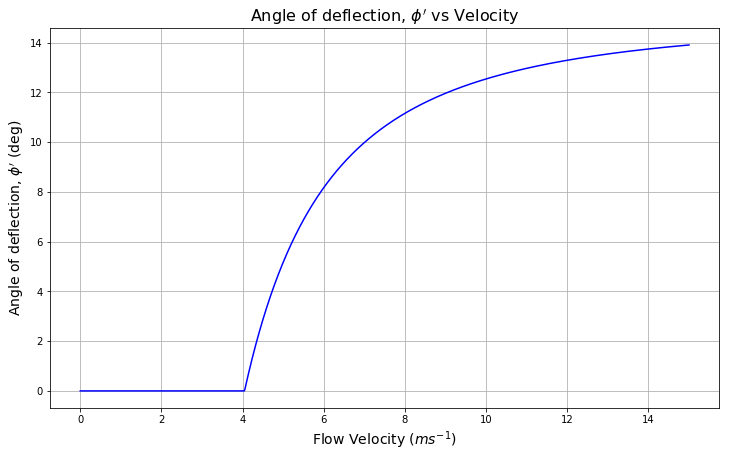

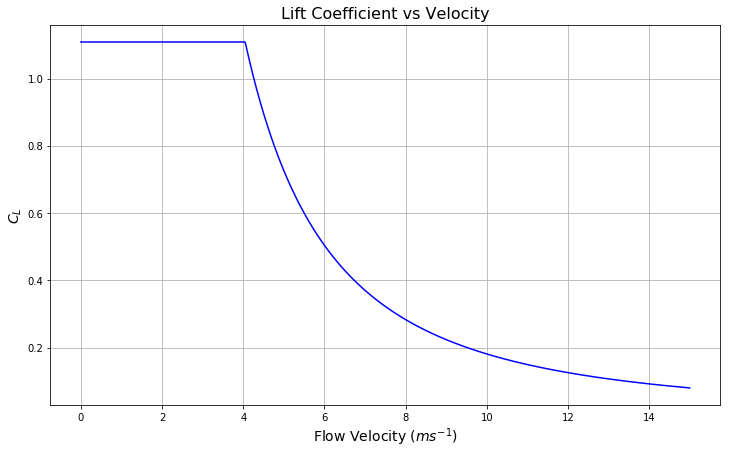

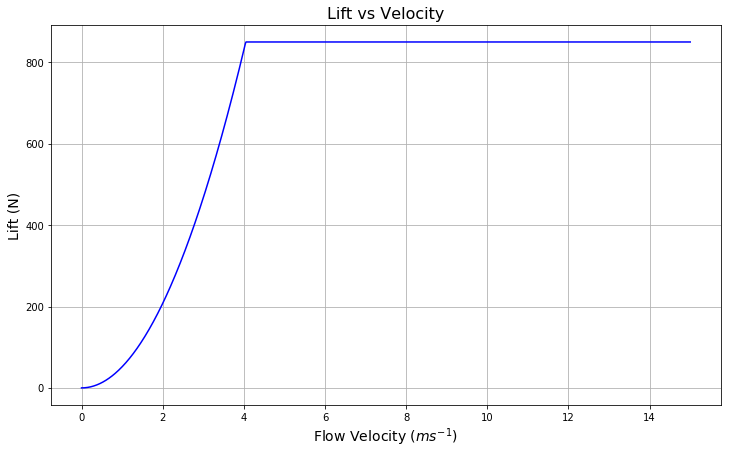

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


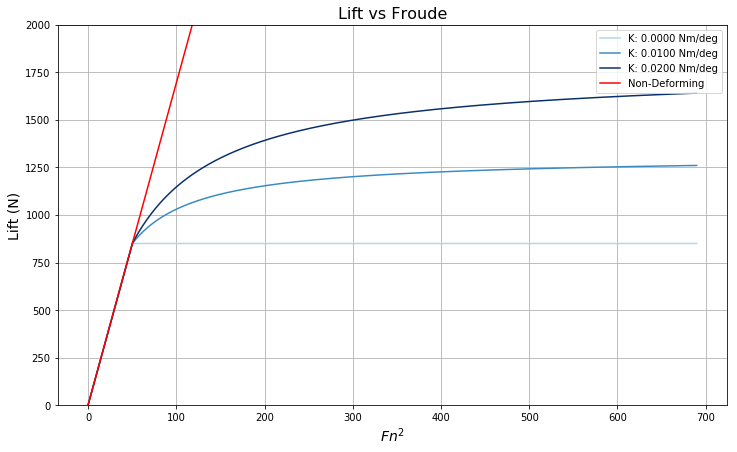

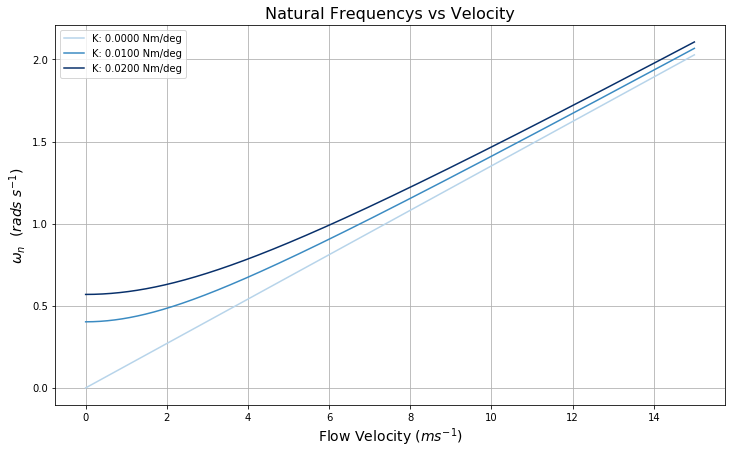

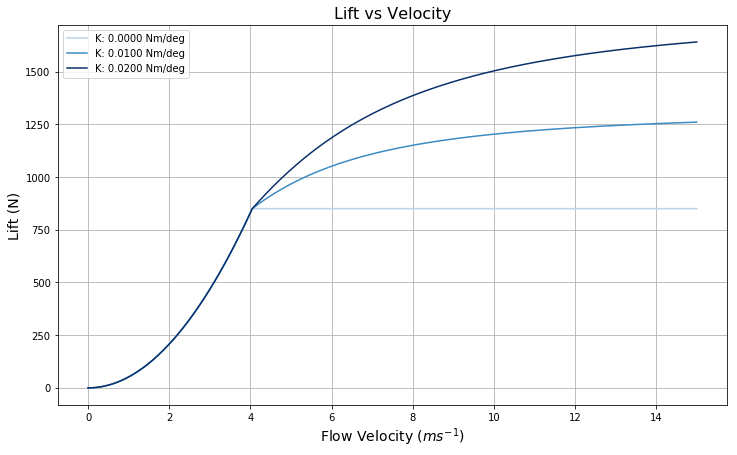

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


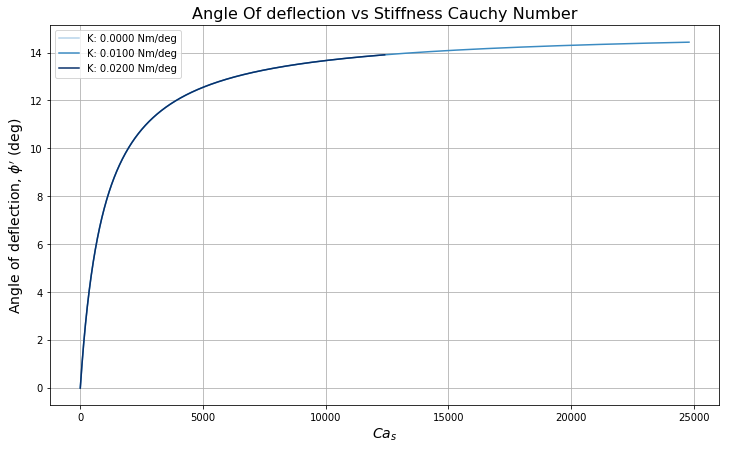

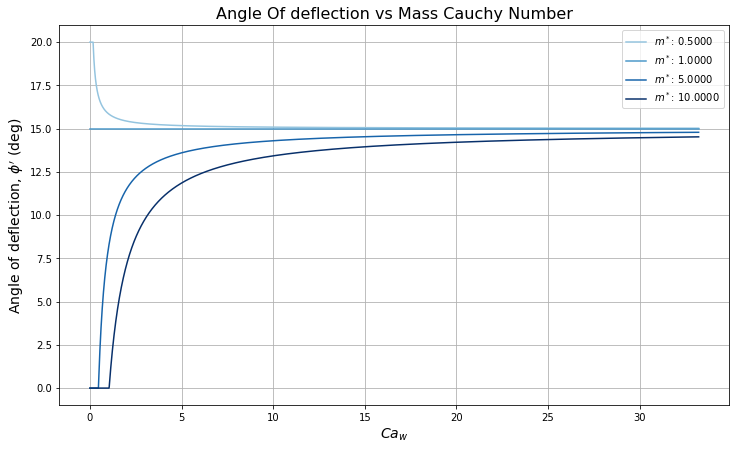

In [24]:

colours = plt.cm.Blues(np.linspace(0.3,1,N))

plt.figure(figsize=(12,7))
plt.plot(velocity, angle, color = "b")
plt.xlabel('Flow Velocity $(ms^{-1})$', size=14)
plt.ylabel("Angle of deflection, $\phi'$ (deg)",size=14)
plt.title("Angle of deflection, $\phi'$ vs Velocity",size=16)
plt.grid(which='major')
plt.savefig('Deflection vs Velocity',bbox_inches='tight', dpi=150)
plt.show()

plt.figure(figsize=(12,7))
plt.plot(velocity, liftCoefficient, color = "b")
plt.xlabel('Flow Velocity $(ms^{-1})$', size=14)
plt.ylabel('$C_L$',size=14)
plt.title('Lift Coefficient vs Velocity',size=16)
plt.grid(which='major')
plt.savefig('LiftCoeff vs Velocity',bbox_inches='tight', dpi=150)
plt.show()

plt.figure(figsize=(12,7))
plt.plot(velocity, lift, color = "b")
plt.xlabel('Flow Velocity $(ms^{-1})$', size=14)
plt.ylabel('Lift (N)',size=14)
plt.title('Lift vs Velocity',size=16)
plt.grid(which='major')
plt.savefig('Lift vs Velocity',bbox_inches='tight', dpi=150)
plt.show()

plt.figure(figsize=(12,7))

for i in range(0,N):
    minStiffness, maxStiffness = 0.0, 0.04
    stiffnesses = [0.0, 0.01, 0.02]
    
    angles, liftCoefficients, lifts, stiffnessCauchys, massCauchys, naturalFreqs = Sweep(stiffnesses, massRatios, velocities, N, AOA)

    plt.plot((velocity**2)/(G*FLAP_CHORD), lifts[i], color = colours[i], label = 'K: {0:.4f} Nm/deg'.format(stiffnesses[i]))

    
plt.plot((velocity**2)/(G*FLAP_CHORD), liftVelocity(1000,massPerSpan,AOA,velocities)[2], color = "r", label = "Non-Deforming")
plt.xlabel('$Fn^2$', size=14)
plt.ylabel('Lift (N)',size=14)
plt.title('Lift vs Froude',size=16)
plt.ylim(0,2000)
plt.grid(which='major')
plt.legend()
plt.savefig('Lift vs Froude',bbox_inches='tight', dpi=150)
plt.show()

plt.figure(figsize=(12,7))
for i in range(0,N):
    angles, liftCoefficients, lifts, stiffnessCauchys, massCauchys, naturalFreqs = Sweep(stiffnesses, massRatios, velocities, N, AOA)

    plt.plot(velocity, naturalFreqs[i], color = colours[i], label = 'K: {0:.4f} Nm/deg'.format(stiffnesses[i]))
    
plt.xlabel('Flow Velocity $(ms^{-1})$', size=14)
plt.ylabel('$\omega_n$  ($rads \ s^{-1}$)',size=14)
plt.title('Natural Frequencys vs Velocity',size=16)
plt.grid(which='major')
plt.legend()
plt.savefig('NatFreq vs Velocity',bbox_inches='tight', dpi=150)
plt.show()

plt.figure(figsize=(12,7))    
for i in range(0,N):
    stiffnesses = [0.0, 0.01, 0.02]
    
    colours = plt.cm.Blues(np.linspace(0.3,1,N))
    
    angles, liftCoefficients, lifts, stiffnessCauchys, massCauchys, naturalFreqs = Sweep(stiffnesses, massRatios, velocities, N, AOA)
    
    plt.plot(velocity, lifts[i], color = colours[i], label = 'K: {0:.4f} Nm/deg'.format(stiffnesses[i]))
    
plt.xlabel('Flow Velocity $(ms^{-1})$', size=14)
plt.ylabel("Lift (N)",size=14)
plt.title('Lift vs Velocity',size=16)
plt.grid(which='major')
plt.legend()
plt.savefig('Lift vs Velocity Multiple K',bbox_inches='tight', dpi=150)
plt.show()
    
plt.figure(figsize=(12,7))
for i in range(0,N):
    massRatios = [1,1,1]
    
    angles, liftCoefficients, lifts, stiffnessCauchys, massCauchys, naturalFreqs = Sweep(stiffnesses, massRatios, velocities, N, AOA)
    
    plt.plot(stiffnessCauchys[i], angles[i], color = colours[i], label = 'K: {0:.4f} Nm/deg'.format(stiffnesses[i]))
    
plt.xlabel('$Ca_s$', size=14)
plt.ylabel("Angle of deflection, $\phi'$ (deg)",size=14)
plt.title('Angle Of deflection vs Stiffness Cauchy Number',size=16)
plt.grid(which='major')
plt.legend()
plt.savefig('Deflection vs SpringCauchy',bbox_inches='tight', dpi=150)
plt.show()
    
plt.figure(figsize=(12,7))    
for i in range(0,4):
    stiffnesses = [0,0,0,0]
    massRatios = [0.5,1,5,10]
    
    colours = plt.cm.Blues(np.linspace(0.4,1,4))
    
    angles, liftCoefficients, lifts, stiffnessCauchys, massCauchys, naturalFreqs = Sweep(stiffnesses, massRatios, velocities, N, AOA)
    
    plt.plot(massCauchys[i], angles[i], color = colours[i], label = '$m^*$: {0:.4f}'.format(massRatios[i]))
    
plt.xlabel('$Ca_w$', size=14)
plt.ylabel("Angle of deflection, $\phi'$ (deg)",size=14)
plt.title('Angle Of deflection vs Mass Cauchy Number',size=16)
plt.grid(which='major')
plt.legend()
plt.savefig('Deflection vs MassCauchy',bbox_inches='tight', dpi=150)
plt.show()